This script is for training emotion classification models with emotion intensity list data. In order to create single label models, I modified this script to use values in Primary Emotion columns as correct labels instead of values in the emotion intensity list column.

In [1]:
# Required Libraries
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
# Clearing the CUDA cache to free memory on GPU.
torch.cuda.empty_cache()

In [ ]:
! pip install -U accelerate
! pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 7.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
! wget https://github.com/ids-cv/wrime/raw/master/wrime-ver2.tsv


--2024-06-08 08:56:24--  https://github.com/ids-cv/wrime/raw/master/wrime-ver2.tsv
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver2.tsv [following]
--2024-06-08 08:56:24--  https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver2.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8182156 (7.8M) [text/plain]
Saving to: ‘wrime-ver2.tsv’

wrime-ver2.tsv      100%[===================>]   7.80M  --.-KB/s    in 0.02s   

2024-06-08 08:56:25 (434 MB/s) - ‘wrime-ver2.tsv’ saved [8182156/8182156]



In [3]:
df_wrime = pd.read_table('wrime-ver2.tsv')

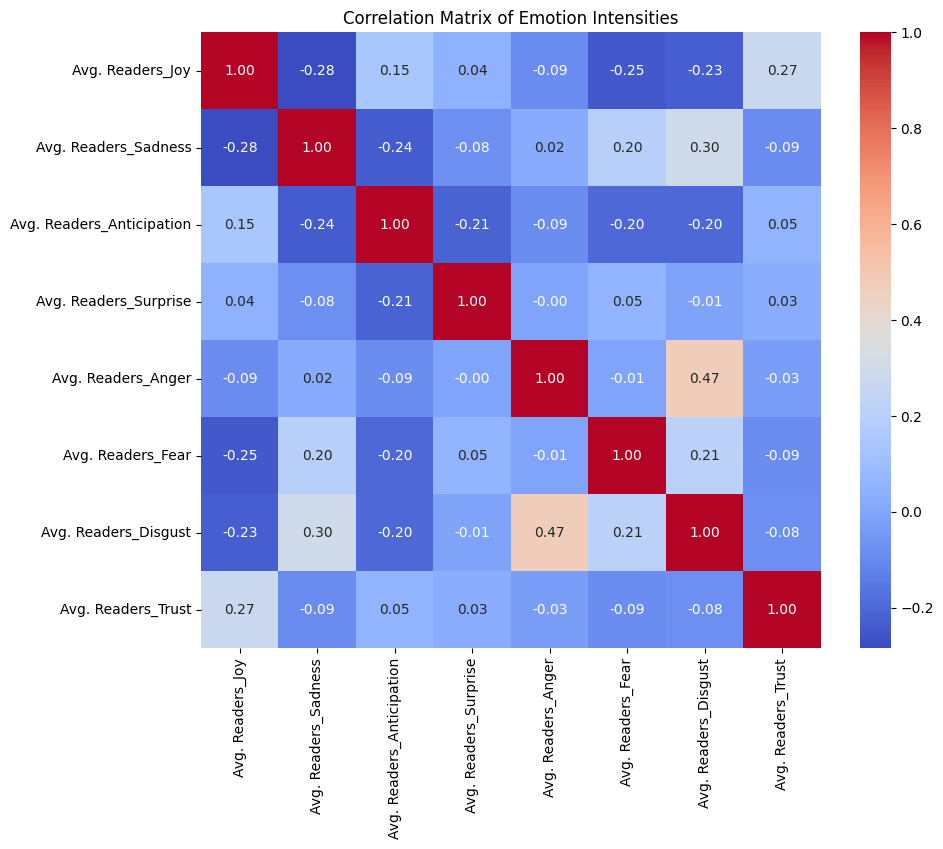

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

emotion_columns = ['Avg. Readers_Joy', 'Avg. Readers_Sadness', 'Avg. Readers_Anticipation', 'Avg. Readers_Surprise', 'Avg. Readers_Anger', 'Avg. Readers_Fear', 'Avg. Readers_Disgust','Avg. Readers_Trust']


# Calculating the correlation matrix
correlation_matrix = df_wrime[emotion_columns].corr()

# Plotting the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Emotion Intensities')
plt.show()

In [5]:
# Calculate average sentiment score for each emotion
weighted_avg_scores = {}

for emotion in emotion_columns:
    # Calculate sentiment score for each row
    df_wrime[f'{emotion}_WeightedSentiment'] = df_wrime[emotion] * df_wrime['Avg. Readers_Sentiment']

    # Calculate the sum of sentiment scores and the sum of emotion intensities
    sum_weighted_sentiment = df_wrime[f'{emotion}_WeightedSentiment'].sum()
    sum_emotion_intensity = df_wrime[emotion].sum()

    # Calculate average sentiment score if the sum of emotion intensities is not zero
    if sum_emotion_intensity != 0:
        weighted_avg = sum_weighted_sentiment / sum_emotion_intensity
    else:
        weighted_avg = None  # Handle case where there is no intensity to avoid division by zero

    # Store the result
    weighted_avg_scores[emotion] = weighted_avg

# Convert the results to a DataFrame
weighted_avg_scores_df = pd.DataFrame(list(weighted_avg_scores.items()), columns=['Emotion', 'Weighted Avg. Sentiment Score'])

print(weighted_avg_scores_df)

                     Emotion  Weighted Avg. Sentiment Score
0           Avg. Readers_Joy                       1.117353
1       Avg. Readers_Sadness                      -1.029128
2  Avg. Readers_Anticipation                       0.653459
3      Avg. Readers_Surprise                       0.050611
4         Avg. Readers_Anger                      -1.365032
5          Avg. Readers_Fear                      -0.892089
6       Avg. Readers_Disgust                      -1.148589
7         Avg. Readers_Trust                       1.197159


In [6]:
#Get fresh data after data analysis
df_wrime = pd.read_table('wrime-ver2.tsv')

# Function to calculate the maximum emotion intensity in each row
def max_emotion_intensity(row):
    avg_readers_emotions = {emotion: row[emotion] for emotion in row.index if emotion.startswith('Avg. Readers_') and emotion != 'Avg. Readers_Sentiment'}
    max_intensity = max(avg_readers_emotions.values())
    return max_intensity

# Apply the function to each row to get the max emotion intensity
df_wrime['Max_Emotion_Intensity'] = df_wrime.apply(max_emotion_intensity, axis=1)

# Filter out rows where the max emotion intensity is 0
df_wrime = df_wrime[df_wrime['Max_Emotion_Intensity'] > 0]

In [ ]:
# Define the sentiment scores for each emotion
emotion_sentiment_scores = {
    "Joy": 1.117353,
    "Sadness": -1.029128,
    "Anticipation": 0.653459,
    "Surprise": 0.050611,
    "Anger": -1.365032,
    "Fear": -0.892089,
    "Disgust": -1.148589,
    "Trust": 1.197159
}

def adjust_primary_emotion_intensity_for_ties(row):
    # Extract only the Avg. Readers_ emotions and their scores, excluding Avg. Readers_Sentiment
    avg_readers_emotions = {emotion: row[emotion] for emotion in row.index if emotion.startswith('Avg. Readers_') and emotion != 'Avg. Readers_Sentiment'}

    # Find the maximum intensity among the Avg. Readers_ emotions
    max_intensity = max(avg_readers_emotions.values())
    # Count how many emotions share this maximum intensity
    emotions_with_max_intensity = [emotion for emotion, intensity in avg_readers_emotions.items() if intensity == max_intensity]

    # Proceed only if there's a tie for the maximum intensity
    if len(emotions_with_max_intensity) > 1:
        avg_readers_sentiment = row['Avg. Readers_Sentiment']

        # Find the emotion (from those with max intensity) whose sentiment score is closest to the Avg. Readers_Sentiment
        closest_emotion = min(emotions_with_max_intensity, key=lambda x: abs(emotion_sentiment_scores[x.replace('Avg. Readers_', '')] - avg_readers_sentiment))

        # Adjust the intensity of the closest emotion by adding an insignificant number (0.01)
        row[closest_emotion] += 0.01
        row['Max_Emotion_Intensity'] = max_intensity + 0.01

    return row

In [ ]:
# Apply the adjustment function to each row
df_wrime = df_wrime.apply(adjust_primary_emotion_intensity_for_ties, axis=1)

In [ ]:
# Function to determine the primary emotion for each row
def determine_primary_emotion(row):
    # Extract only the Avg. Readers_ emotions and their scores, excluding Avg. Readers_Sentiment
    avg_readers_emotions = {emotion: row[emotion] for emotion in row.index if emotion.startswith('Avg. Readers_') and emotion != 'Avg. Readers_Sentiment'}

    # Find the emotion with the highest intensity
    primary_emotion = max(avg_readers_emotions, key=avg_readers_emotions.get)
    return primary_emotion.replace('Avg. Readers_', '')

# Apply the function to each row to identify the primary emotion
df_wrime['Primary_Emotion'] = df_wrime.apply(determine_primary_emotion, axis=1)

In [ ]:
# Plutchik 8 emotions
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear', 'Disgust', 'Trust']

# Make a emotion intensity list and create a new column
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

In [ ]:
from sklearn.model_selection import train_test_split

# Splitting the DataFrame into train, validation, and test sets
# First, split into train+dev and test
train_dev_df, df_test = train_test_split(df_wrime, test_size=0.2, random_state=42)
# Then, split train+dev into train and dev
df_train, df_dev = train_test_split(train_dev_df, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 23.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


In [ ]:
# Installing necessary packages for Japanese Bert
! pip install fugashi ipadic


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 95.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=ee89d4ba266208bdf68da5610a3512700668dfac86b2dc42cf4104b000fdbb2d
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# Create a configuration with modified dropout rates and specify num_labels
config = AutoConfig.from_pretrained(checkpoint,
                                    num_labels=8,
                                    hidden_dropout_prob=0.3,
                                    attention_probs_dropout_prob=0.3)

# Initialize the model with the modified configuration
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from datasets import Dataset
import numpy as np


#Convert into Transformer dataset
# pandas.DataFrame -> datasets.Dataset
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])
dev_dataset = Dataset.from_pandas(df_dev[target_columns])

# Function to tokenize and normalize emotional intensity data
def tokenize_function(batch):
    """Tokenization and normalization of emotional intensity"""
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length', max_length=128)
    tokenized_batch['labels'] = [x / np.sum(x) for x in batch['readers_emotion_intensities']]  # Normalize the total sum to 1
    return tokenized_batch

# Applying tokenization to the datasets
train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)
dev_tokenized_dataset = dev_dataset.map(tokenize_function, batched=True)


print(train_tokenized_dataset[1])

Parameter 'function'=<function tokenize_function at 0x7d37c1f523b0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/19714 [00:00<?, ? examples/s]

Map:   0%|          | 0/6572 [00:00<?, ? examples/s]

Map:   0%|          | 0/6572 [00:00<?, ? examples/s]

{'Sentence': 'Kahvitauko（カハヴィタウコ）あふた。\n昨日と同じ豆。\n湯温を90℃にして挽目を少し荒くしたら苦味が消えました。\n澄んだ琥珀色ながら、しっかりとまろやかに。\nやったね', 'readers_emotion_intensities': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '__index_level_0__': 34909, 'input_ids': [2, 27072, 28695, 20740, 21680, 10590, 28538, 23, 103, 28638, 770, 24275, 28539, 24, 22, 10392, 8, 10271, 28486, 13, 552, 8516, 8, 3707, 1560, 11, 2781, 3967, 184, 7, 15, 16, 22423, 28653, 11, 4800, 2661, 28504, 15, 3318, 2155, 29029, 14, 8508, 3913, 10, 8, 10853, 28575, 75, 1, 1232, 895, 6, 13734, 13, 47, 28828, 3877, 7, 8, 5408, 10, 1852, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configuration and training setup using HuggingFace Trainer
from transformers import TrainingArguments, Trainer
from datasets import load_metric

import numpy as np

# Load metrics
accuracy_metric = load_metric("accuracy")
precision_metric = load_metric("precision")
recall_metric = load_metric("recall")
f1_metric = load_metric("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    label_ids = np.argmax(labels, axis=-1)

    # Compute metrics
    accuracy = accuracy_metric.compute(predictions=predictions, references=label_ids)
    precision = precision_metric.compute(predictions=predictions, references=label_ids, average="macro")
    recall = recall_metric.compute(predictions=predictions, references=label_ids, average="macro")
    f1 = f1_metric.compute(predictions=predictions, references=label_ids, average="macro")

    # Return a dictionary with all the metrics
    return {
        "accuracy": accuracy["accuracy"],
        "precision": precision["precision"],
        "recall": recall["recall"],
        "f1": f1["f1"]
    }


training_args = TrainingArguments(
    output_dir='/content/drive/My Drive/modelwithlist',
    num_train_epochs=20,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='epoch',
    save_strategy= 'epoch',             # Save the model at the end of each epoch
    load_best_model_at_end=True,       # Load the best model at the end of training
    metric_for_best_model="eval_loss",
    greater_is_better=False
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=dev_tokenized_dataset,
    compute_metrics=compute_metrics,
)

trainer.train()


<ipython-input-19-4f405bfb5111>:8: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  accuracy_metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for precision contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/precision/precision.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for recall contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/recall/recall.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for f1 contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/f1/f1.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1474: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.319200,0.304530,0.447505,0.241228,0.259152,0.232914


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
